# Instacart Market Basket Analysis


https://www.kaggle.com/c/instacart-market-basket-analysis


## Description

Whether you shop from meticulously planned grocery lists or let whimsy guide your grazing, our unique food rituals define who we are. Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.

## Determine business objectives

### <span style="color:orange;">Which products will an Instacart consumer purchase again?

<span style="color:green;">Use the data on customer orders over time to predict which previously purchased products will be in a user’s next order.

## Dataset Description 


ref: https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b


The dataset is a relational set of files describing customers' orders over time. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, there is between 4 and 100 of their orders, with the sequence of products purchased in each order. It also contains the week and hour of day the order was placed, and a relative measure of time between orders.

### <span style="color:green;">orders (3.4m rows, 206k users)
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

### <span style="color:green;">products (50k rows)
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

### <span style="color:green;">aisles (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

### <span style="color:green;">deptartments (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

### <span style="color:green;">order_products__SET (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)


## Result

For each order_id in the test set, you should predict a space-delimited list of product_ids for that order. If you wish to predict an empty order, you should submit an explicit `None` value. You may combine `None` with product_ids. The spelling of `None` is case sensitive in the scoring metric. The file should have a header and look like the following:

```
order_id,products  
17,1 2  
34,None  
137,1 2 3  
etc.
```



In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [3]:
#%config Completer.use_jedi = True

# Data Understanding

## Collecting Initial Data

In [6]:
%%time
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
orders_products_prior = pd.read_csv('data/order_products__prior.csv')
orders_products_train = pd.read_csv('data/order_products__train.csv')

CPU times: user 7.28 s, sys: 2.03 s, total: 9.31 s
Wall time: 9.39 s


## Describe Data

### aisles

In [16]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [18]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [20]:
aisles.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

In [22]:
aisles.duplicated().sum()

0

In [24]:
aisles.nunique()

aisle_id    134
aisle       134
dtype: int64

In [26]:
aisles.describe()

,aisle_id
count,134.000000
mean,67.500000
std,38.826537
min,1.000000
25%,34.250000
50%,67.500000
75%,100.750000
max,134.000000


In [28]:
aisles.describe(include=[object])

,aisle
count,134
unique,134
top,prepared soups salads
freq,1


### Departments

In [31]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [33]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


In [35]:
departments.isnull().sum()

department_id    0
department       0
dtype: int64

In [37]:
departments.duplicated().sum()

0

In [39]:
departments.nunique()

department_id    21
department       21
dtype: int64

In [41]:
departments.describe()

,department_id
count,21.000000
mean,11.000000
std,6.204837
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,21.000000


In [43]:
departments.describe(include=[object])

,department
count,21
unique,21
top,frozen
freq,1


### Orders

In [46]:
orders.head(12)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [48]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [50]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [52]:
# days_since_prior_order is expected to have null when order_number is 1. Lets do this again ignoring order_number = 1
orders.loc[orders['order_number'] != 1].isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [54]:
orders.duplicated().sum()

0

In [56]:
orders.nunique()

order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [58]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [60]:
orders.describe(include=[object])

,eval_set
count,3421083
unique,3
top,prior
freq,3214874


### Products

In [63]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [65]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [67]:
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [69]:
products.duplicated().sum()

0

In [71]:
products.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64

In [73]:
products.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


In [75]:
products.describe(include=[object])

,product_name
count,49688
unique,49688
top,Chocolate Sandwich Cookies
freq,1


### Orders Products prior to that users most recent order

In [78]:
orders_products_prior.head(20)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [80]:
orders_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [82]:
orders_products_prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [86]:
%%time
orders_products_prior.duplicated().sum()

CPU times: user 7.71 s, sys: 1.8 s, total: 9.51 s
Wall time: 9.6 s


0

In [88]:
orders_products_prior.nunique()

order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64

In [90]:
orders_products_prior.describe()

,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


### Orders Products training data

In [98]:
orders_products_train.head(20)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [100]:
orders_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [102]:
orders_products_train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [104]:
orders_products_train.duplicated().sum()

0

In [106]:
orders_products_train.nunique()

order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64

In [108]:
orders_products_train.describe()

,order_id,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,2.555624e+04,8.758044e+00,5.985944e-01
std,9.897326e+05,1.412127e+04,7.423936e+00,4.901829e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,2.529800e+04,7.000000e+00,1.000000e+00
75%,2.568023e+06,3.794000e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,4.968800e+04,8.000000e+01,1.000000e+00


## Pre EDA

### combining orders_products_prior and orders_products_train as orders_products

In [116]:
# combining train and prior orders_products
orders_products = pd.concat(objs=[orders_products_train, orders_products_prior])

In [118]:
orders_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [120]:
orders_products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33819106 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 1.3 GB


In [122]:
orders_products.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [126]:
%%time
orders_products.duplicated().sum()

CPU times: user 7.18 s, sys: 1.55 s, total: 8.73 s
Wall time: 8.89 s


0

In [128]:
orders_products.nunique()

order_id             3346083
product_id             49685
add_to_cart_order        145
reordered                  2
dtype: int64

In [130]:
orders_products.describe()

,order_id,product_id,add_to_cart_order,reordered
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07
mean,1.710566e+06,2.557551e+04,8.367738e+00,5.900617e-01
std,9.874008e+05,1.409770e+04,7.139540e+00,4.918220e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.554130e+05,1.351900e+04,3.000000e+00,0.000000e+00
50%,1.710660e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565587e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


### orders_products_extended by merging orders_products with products, aisles and departments

In [133]:
%%time
orders_products_extended = pd.merge(left=orders_products, right=products, on='product_id', how='left')
orders_products_extended = pd.merge(left=orders_products_extended, right=aisles, on='aisle_id', how='left')
orders_products_extended = pd.merge(left=orders_products_extended, right=departments, on='department_id', how='left')

CPU times: user 11.6 s, sys: 4.61 s, total: 16.2 s
Wall time: 17 s


In [138]:
orders_products_extended.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [136]:
orders_products_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   order_id           int64 
 1   product_id         int64 
 2   add_to_cart_order  int64 
 3   reordered          int64 
 4   product_name       object
 5   aisle_id           int64 
 6   department_id      int64 
 7   aisle              object
 8   department         object
dtypes: int64(6), object(3)
memory usage: 2.3+ GB


In [140]:
%%time
orders_products_extended.isnull().sum()

CPU times: user 3.55 s, sys: 88.3 ms, total: 3.64 s
Wall time: 3.71 s


order_id             0
product_id           0
add_to_cart_order    0
reordered            0
product_name         0
aisle_id             0
department_id        0
aisle                0
department           0
dtype: int64

In [142]:
%%time
orders_products_extended.duplicated().sum()

CPU times: user 22.3 s, sys: 3.65 s, total: 26 s
Wall time: 26.5 s


0

In [143]:
%%time
orders_products_extended.nunique()

CPU times: user 7.49 s, sys: 268 ms, total: 7.76 s
Wall time: 7.78 s


order_id             3346083
product_id             49685
add_to_cart_order        145
reordered                  2
product_name           49685
aisle_id                 134
department_id             21
aisle                    134
department                21
dtype: int64

In [146]:
%%time
orders_products_extended.describe()

CPU times: user 5.63 s, sys: 890 ms, total: 6.52 s
Wall time: 6.58 s


,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07
mean,1.710566e+06,2.557551e+04,8.367738e+00,5.900617e-01,7.121799e+01,9.918544e+00
std,9.874008e+05,1.409770e+04,7.139540e+00,4.918220e-01,3.819898e+01,6.281655e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.554130e+05,1.351900e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00
50%,1.710660e+06,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00
75%,2.565587e+06,3.793500e+04,1.100000e+01,1.000000e+00,1.070000e+02,1.600000e+01
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01


In [148]:
%%time
orders_products_extended.describe(include=[object])

CPU times: user 10.6 s, sys: 980 ms, total: 11.6 s
Wall time: 11.8 s


,product_name,aisle,department
count,33819106,33819106,33819106
unique,49685,134,21
top,Banana,fresh fruits,produce
freq,491291,3792661,9888378


### Merging products, aisles and departments as inventory

In [151]:
inventory = pd.merge(left=products, right=aisles, on='aisle_id', how='left')
inventory = pd.merge(left=inventory, right=departments, on='department_id', how='left')

In [153]:
inventory.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [155]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
 4   aisle          49688 non-null  object
 5   department     49688 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.3+ MB


In [157]:
inventory.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
aisle            0
department       0
dtype: int64

In [159]:
inventory.duplicated().sum()

0

In [161]:
inventory.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
aisle              134
department          21
dtype: int64

In [163]:
inventory.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
aisle              134
department          21
dtype: int64

In [165]:
inventory.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


In [167]:
inventory.describe(include=[object])

,product_name,aisle,department
count,49688,49688,49688
unique,49688,134,21
top,Chocolate Sandwich Cookies,missing,personal care
freq,1,1258,6563


## EDA - Exploratory Data Analysis

* How many orders each user made using histogram.
* Which products are ordered the most
* Which products are reordered the most
* How often products are reordered using histogram.
* Aisle with more products.
* Departments with more products.
* Products share by Department and Aisle using Treemap.



When a user orders a product, what is the change of it being reordered?

### How many orders each user made

In [171]:
orders.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0


In [173]:
%%time
orders_by_user = orders.groupby(['user_id'])['order_number'].max().reset_index()

CPU times: user 85.9 ms, sys: 40 ms, total: 126 ms
Wall time: 125 ms


In [174]:
orders_by_user.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


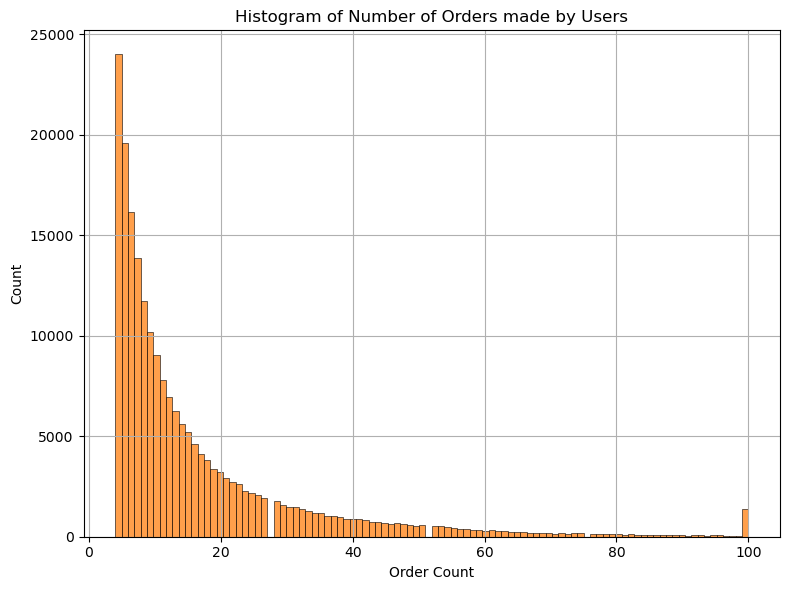

In [228]:
plt.figure(figsize=(8,6))
sns.histplot(data=orders_by_user['order_number'], color='tab:orange', bins=100)
plt.xlabel('Order Count')
plt.ylabel('Count')
plt.title('Histogram of Number of Orders made by Users')
plt.grid()
plt.tight_layout()
plt.savefig('images/orders_by_users_histo.png')
plt.show()

### Which products are ordered the most

In [236]:
%%time
product_name_df = orders_products_extended['product_name'].value_counts().reset_index()

CPU times: user 3.07 s, sys: 42.9 ms, total: 3.12 s
Wall time: 3.17 s


In [237]:
product_name_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49685 entries, 0 to 49684
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  49685 non-null  object
 1   count         49685 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 776.5+ KB


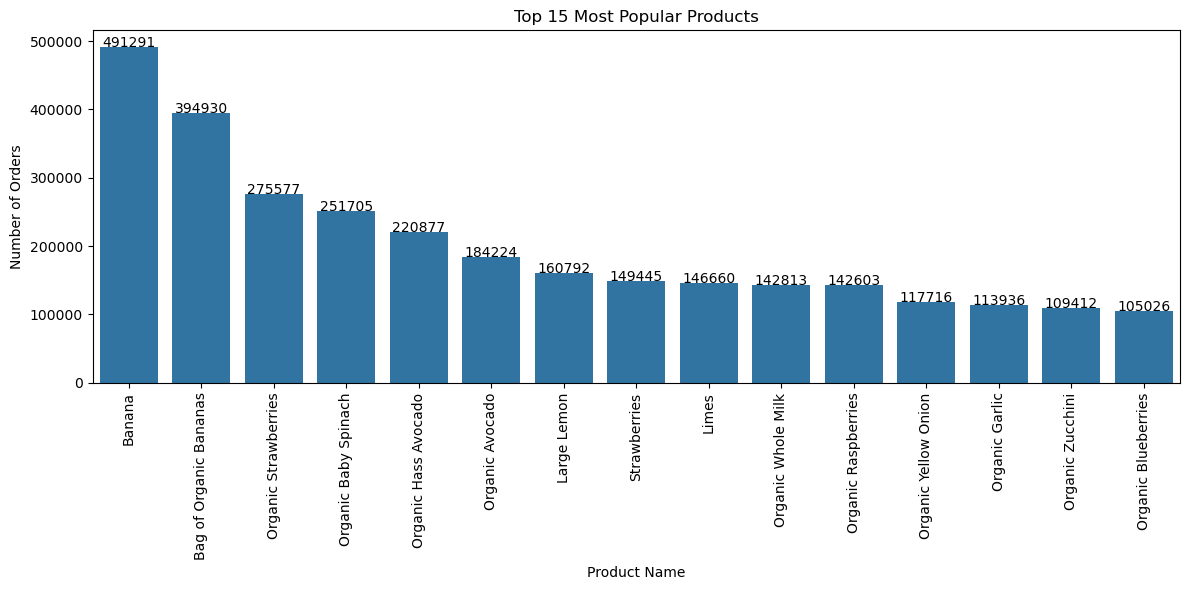

In [238]:
top_n = 15
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=product_name_df.head(top_n), x='product_name', y='count')
for index, count in enumerate(product_name_df.head(top_n)['count']):
    bar_plot.text(index, count, s=f'{count}', color='black', ha="center")
# plt.tight_layout()
plt.title(f'Top {top_n} Most Popular Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/top_most_popular_products.png')
plt.show()


### Which products are reordered the most

In [243]:
products_reordered_df = orders_products_extended.loc[orders_products_extended['reordered'] == 1]['product_name'].\
    value_counts().reset_index()

In [244]:
products_reordered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45603 entries, 0 to 45602
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  45603 non-null  object
 1   count         45603 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 712.7+ KB


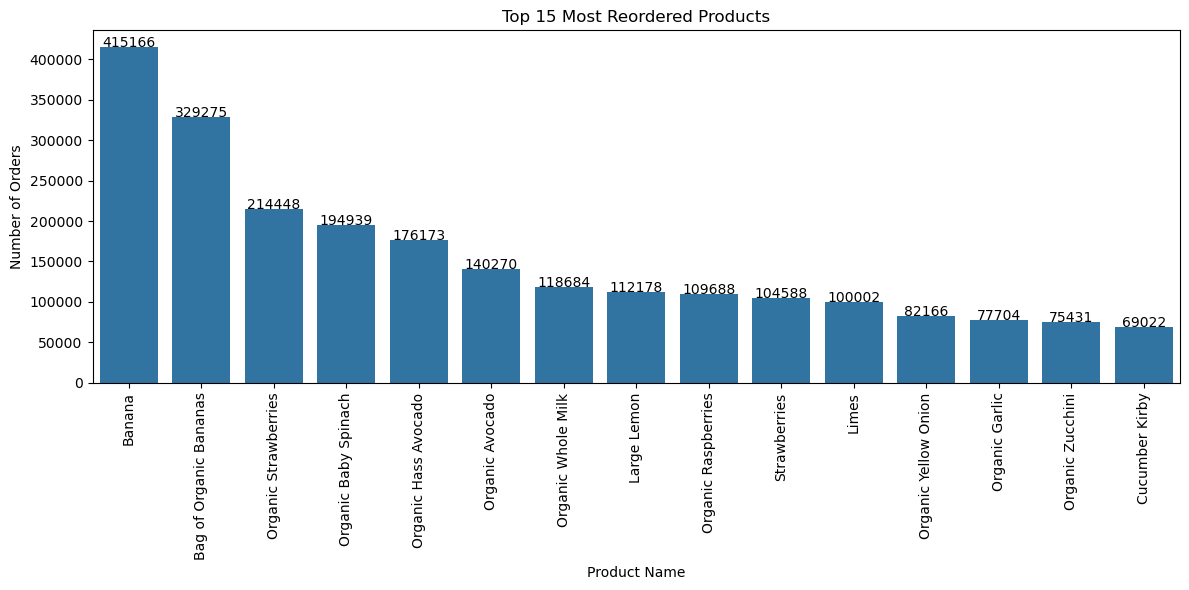

In [247]:
top_n = 15
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=products_reordered_df.head(top_n), x='product_name', y='count')
for index, count in enumerate(products_reordered_df.head(top_n)['count']):
    bar_plot.text(index, count, s=f'{count}', color='black', ha="center")
# plt.tight_layout()
plt.title(f'Top {top_n} Most Reordered Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/top_most_reordered_products.png')
plt.show()

### How often products are reordered using histogram

In [250]:
%%time
products_reordered = orders_products_extended['product_name'].value_counts().reset_index()

CPU times: user 3.1 s, sys: 47.4 ms, total: 3.14 s
Wall time: 3.13 s


In [251]:
products_reordered.head()

,product_name,count
0,Banana,491291
1,Bag of Organic Bananas,394930
2,Organic Strawberries,275577
3,Organic Baby Spinach,251705
4,Organic Hass Avocado,220877


In [254]:
products_reordered['count'] = products_reordered['count'].apply(lambda x: min(x, 500))

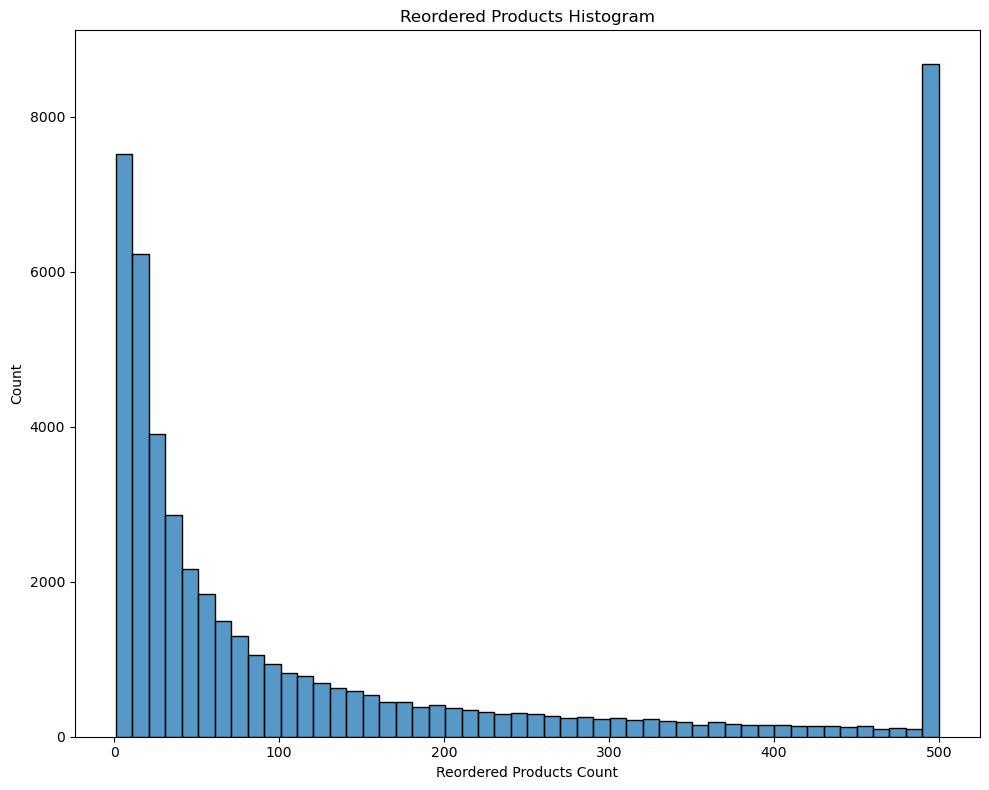

CPU times: user 499 ms, sys: 87.3 ms, total: 586 ms
Wall time: 324 ms


In [256]:
%%time
plt.figure(figsize=(10, 8))
sns.histplot(data=products_reordered['count'], bins=50)
plt.title(f'Reordered Products Histogram')
plt.xlabel('Reordered Products Count')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/reordered_products_histo.png')
plt.show()

### Which Aisles and Departments have more products

In [260]:
inventory.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [262]:
top_aisles = inventory.groupby('aisle').count()['product_id'].sort_values(ascending=False).reset_index()

In [264]:
top_aisles.head()

,aisle,product_id
0,missing,1258
1,candy chocolate,1246
2,ice cream ice,1091
3,vitamins supplements,1038
4,yogurt,1026


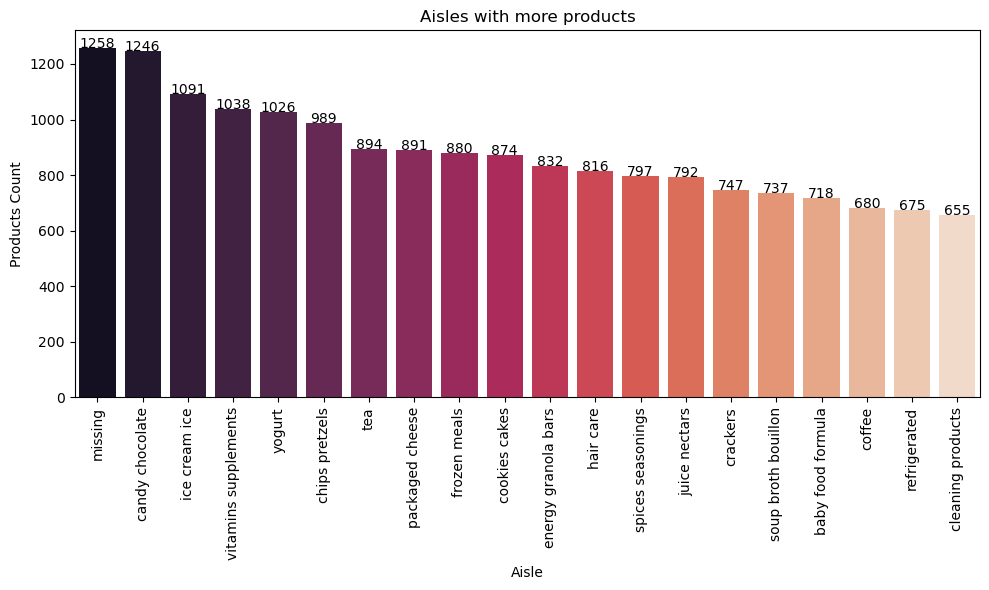

In [266]:
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=top_aisles.head(20), x='aisle', y='product_id', palette='rocket', hue='aisle')
for index, value in enumerate(top_aisles.head(20)['product_id']):
    bar_plot.text(x=index, y=value, s=f'{value}', ha='center')
plt.title('Aisles with more products')
plt.xlabel('Aisle')
plt.ylabel('Products Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/aisles_with_products.png')
plt.show()

In [268]:
top_departments = inventory.groupby('department').count()['product_id'].sort_values(ascending=False).reset_index()

In [270]:
top_departments.head()

,department,product_id
0,personal care,6563
1,snacks,6264
2,pantry,5371
3,beverages,4365
4,frozen,4007


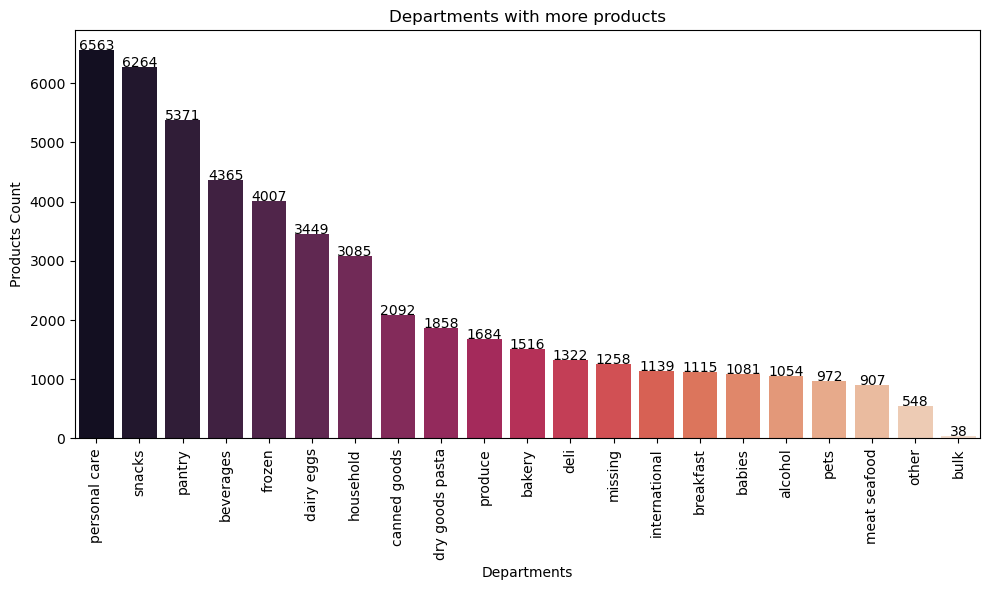

In [272]:
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=top_departments, x='department', y='product_id', palette='rocket', hue='department')
for index, value in enumerate(top_departments['product_id']):
    bar_plot.text(x=index, y=value, s=f'{value}', ha='center')
plt.title('Departments with more products')
plt.xlabel('Departments')
plt.ylabel('Products Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/departments_with_products.png')
plt.show()

### Product Treemap by Department and Aisle

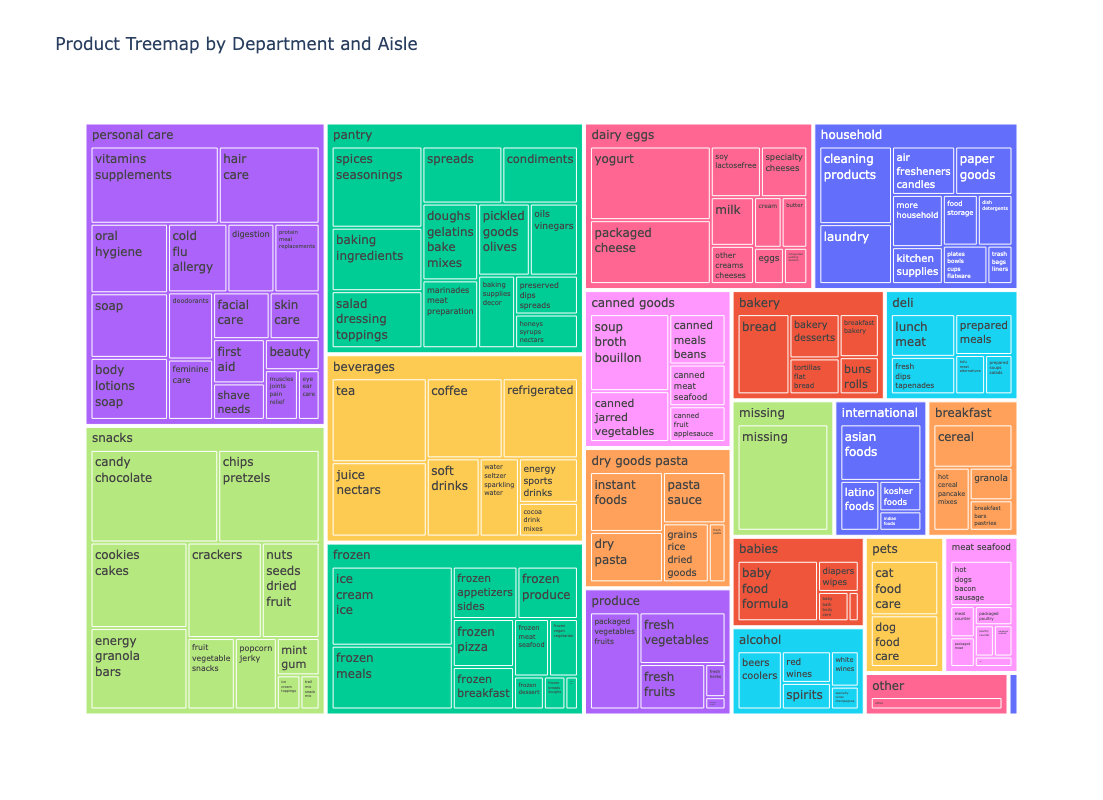

CPU times: user 446 ms, sys: 36.6 ms, total: 483 ms
Wall time: 5.78 s


In [277]:
%%time

import plotly.express as px
import textwrap

# Aggregate data by department and aisle
aggregated_data = inventory.groupby(['department', 'aisle']).size().reset_index(name='count')

# Function to wrap text for labels
def wrap_text(text, width=5):
    words = text.split(' ')
    lines = []
    current_line = []
    current_length = 0
    for word in words:
        if current_length + len(word) + 1 <= width:
            current_line.append(word)
            current_length += len(word) + 1
        else:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word) + 1
    lines.append(' '.join(current_line))
    return '<br>'.join(lines)

# Apply word wrapping to labels
# textwrap is not helpful when you want text wrap on space first and then on width. So, it could wrap word in more than 1 line
# aggregated_data['wrapped_aisle'] = aggregated_data['aisle'].apply(lambda x: "<br>".join(textwrap.wrap(x,width=12)))
aggregated_data['wrapped_aisle'] = aggregated_data['aisle'].apply(lambda x: wrap_text(x))

# Create the treemap with different colors for each department
fig = px.treemap(
    aggregated_data, 
    path=['department', 'wrapped_aisle'], 
    values='count',
    color='department',  # Set color dimension to department
    title='Product Treemap by Department and Aisle',
    width=1100,
    height=800
)

fig.write_image('images/product_treemap.png')
# Show the plot
fig.show()


## Data Preparation